In [1]:
from lib_linear import *
import time
import torch.nn.functional as F
from copy import deepcopy



## read diagonalized iinput-input, input-output and output-output matrices

In [2]:
input_input_matrix = np.array(pd.read_csv('input_input_matrix.csv'))
output_input_matrix = np.array(pd.read_csv('output_input_matrix.csv'))
output_output_matrix = np.array(pd.read_csv('output_output_matrix.csv'))

V_matrix = np.array(pd.read_csv('V_matrix.csv'))
U_matrix = np.array(pd.read_csv('U_matrix.csv'))
S31_matrix = np.array(pd.read_csv('S_matrix.csv'))  ##actually, just diag values

S11_matrix = V_matrix.T @ input_input_matrix @ V_matrix
S33_matrix = output_output_matrix

S_improved  = pd.read_csv('500/S_improved.csv')
S11_improved = np.array(S_improved['S11'])
S31_improved = np.array(S_improved['S31'])

## Data

In [3]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

batch_size: int = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Neural network model

In [4]:
class CustomNetwork(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        self.weights = []
        self.D = len(layers_dim)-1
        assert self.D == D
                
        for i in range(self.D):
            weight: torch.Tensor = torch.rand((layers_dim[i+1], layers_dim[i])) 
            stdv = 2/ np.sqrt(layers_dim[i])
            weight = (weight-0.5)*stdv
            weight.requires_grad = True
            self.weights.append(weight)
    
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """
        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
        return x 
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights

In [5]:
input_dim = 784
output_dim = 10
hidden_dim1 = 500
D = 2
model: CustomNetwork = CustomNetwork(D = D, layers_dim = (input_dim, hidden_dim1, output_dim))

## Training parameters

In [6]:
# initialize the optimizer using the hyperparams below
lr: float = 0.005
momentum: float = 0.00
optimizer: torch.optim.Optimizer = SGD(params = model.parameters(), lr=lr)
criterion = nn.MSELoss() 
epoch: int = 3000

In [7]:
term_I_tab=[]
term_II_tab = []
term_IV_tab = []

term_I_star_tab=[]
term_II_star_tab = []
term_IV_star_tab = []

term_I_diamond_tab=[]
term_II_diamond_tab = []
term_IV_diamond_tab = []

## Training loop

In [8]:
for e in range(epoch):
    for inner_counter, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        output: torch.Tensor = model(x)  
        y=F.one_hot(y, num_classes=10).float()
        loss: torch.Tensor = criterion(output, y)
        loss.backward()
        optimizer.step()     
    
    #add model parameters to tab
    loss_tab.append(loss.item())
    params_tab = []
    for param in model.parameters():
        params_tab.append(param.detach().numpy().flatten()  )
    w1_mean_tab.append(params_tab[0].mean())
    w2_mean_tab.append(params_tab[1].mean())
    w1_std_tab.append(params_tab[0].std())
    w2_std_tab.append(params_tab[1].std())

    # at the end of an epoch run evaluation on the test set
    with torch.no_grad():
        correct: int = 0 
        for i, (x, y) in enumerate(train_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        train_accuracy_tab.append( float(correct) / len(train_data))
        correct: int = 0 
        for i, (x, y) in enumerate(test_loader):
            output: torch.Tensor = model(x)
            pred_labels = torch.argmax(output, 1)
            correct += ( (pred_labels -y) ==0).sum()
        test_accuracy_tab.append( float(correct) / len(test_data))
    
    # save params
    params=[]
    for param in model.parameters():
        params.append(param.detach().numpy())
    w1=params[0] 
    w2=params[1]

    R = U_matrix.T @ w2 @ w1 @ V_matrix

    ######################### original terms ########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_matrix[alpha][alpha]

    term_I_tab.append(round(float(term_1), 6))
    term_II_tab.append(round(float(term_2), 6))
    term_IV_tab.append(round(float(term_4), 6))
    
    
    ########################## S11 diamond ##########################
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_matrix[alpha]/S11_improved[alpha])**2 * S11_improved[alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                if alpha <10:
                    term_2 += (R[beta][alpha])**2 * S11_improved[alpha]
                else:
                    term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]

    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_matrix[alpha])**2/S11_improved[alpha]
  
    term_I_diamond_tab.append(round(float(term_1), 6))
    term_II_diamond_tab.append(round(float(term_2), 6))
    term_IV_diamond_tab.append(round(float(term_4), 6))
    
    
    ########################## S31 star ##########################    
    term_1 = 0
    for alpha in range(10):
        term_1 += (R[alpha][alpha] - S31_improved[alpha]/S11_matrix[alpha][alpha])**2 * S11_matrix[alpha][alpha]
    term_2 = 0
    for beta in range(10):
        for alpha in range(784):
            if(alpha != beta):
                term_2 += (R[beta][alpha])**2 *S11_matrix[alpha][alpha]
    term_4 = 0
    for alpha in range(10):
        term_4+= (S31_improved[alpha])**2/S11_matrix[alpha][alpha]
       
    term_I_star_tab.append(round(float(term_1), 6))
    term_II_star_tab.append(round(float(term_2), 6))
    term_IV_star_tab.append(round(float(term_4), 6))
    
    print(f'{e} loss = {loss} test acc {test_accuracy_tab[-1]}')

0 loss = 0.09245636314153671 test acc 0.4139
1 loss = 0.07271570712327957 test acc 0.5857
2 loss = 0.06393024325370789 test acc 0.6635
3 loss = 0.058814600110054016 test acc 0.7089
4 loss = 0.05543902516365051 test acc 0.7362
5 loss = 0.05304073914885521 test acc 0.7559
6 loss = 0.0512472540140152 test acc 0.7713
7 loss = 0.04985293373465538 test acc 0.7822
8 loss = 0.04873499274253845 test acc 0.7923
9 loss = 0.04781583696603775 test acc 0.7989
10 loss = 0.047044262290000916 test acc 0.805
11 loss = 0.046385277062654495 test acc 0.8096
12 loss = 0.04581420123577118 test acc 0.8124
13 loss = 0.04531317576766014 test acc 0.816
14 loss = 0.04486894607543945 test acc 0.8187
15 loss = 0.04447147995233536 test acc 0.8222
16 loss = 0.04411303624510765 test acc 0.825
17 loss = 0.04378754645586014 test acc 0.8277
18 loss = 0.04349015653133392 test acc 0.8294
19 loss = 0.043216973543167114 test acc 0.8309
20 loss = 0.04296479374170303 test acc 0.8319
21 loss = 0.042730994522571564 test acc 0.83

177 loss = 0.03601892665028572 test acc 0.8626
178 loss = 0.03600737825036049 test acc 0.8626
179 loss = 0.035995930433273315 test acc 0.8626
180 loss = 0.035984572023153305 test acc 0.8627
181 loss = 0.035973306745290756 test acc 0.8627
182 loss = 0.03596213459968567 test acc 0.8626
183 loss = 0.03595105558633804 test acc 0.8627
184 loss = 0.03594006225466728 test acc 0.8627
185 loss = 0.035929158329963684 test acc 0.8628
186 loss = 0.03591833636164665 test acc 0.8627
187 loss = 0.03590760752558708 test acc 0.8627
188 loss = 0.03589696064591408 test acc 0.8628
189 loss = 0.03588639572262764 test acc 0.8628
190 loss = 0.035875916481018066 test acc 0.8627
191 loss = 0.03586551919579506 test acc 0.8629
192 loss = 0.03585520014166832 test acc 0.8629
193 loss = 0.035844963043928146 test acc 0.8629
194 loss = 0.03583480045199394 test acc 0.8629
195 loss = 0.035824719816446304 test acc 0.8629
196 loss = 0.035814717411994934 test acc 0.8629
197 loss = 0.03580478951334953 test acc 0.8629
198 l

351 loss = 0.03484827280044556 test acc 0.8627
352 loss = 0.03484440967440605 test acc 0.8627
353 loss = 0.03484056144952774 test acc 0.8627
354 loss = 0.03483673557639122 test acc 0.8626
355 loss = 0.03483292832970619 test acc 0.8625
356 loss = 0.034829143434762955 test acc 0.8625
357 loss = 0.03482537344098091 test acc 0.8625
358 loss = 0.03482162952423096 test acc 0.8625
359 loss = 0.0348178893327713 test acc 0.8625
360 loss = 0.03481417894363403 test acc 0.8625
361 loss = 0.03481047973036766 test acc 0.8625
362 loss = 0.03480680286884308 test acc 0.8627
363 loss = 0.03480314090847969 test acc 0.8627
364 loss = 0.03479950129985809 test acc 0.8627
365 loss = 0.03479587286710739 test acc 0.8627
366 loss = 0.03479226678609848 test acc 0.8627
367 loss = 0.03478867933154106 test acc 0.8625
368 loss = 0.03478510305285454 test acc 0.8625
369 loss = 0.034781549125909805 test acc 0.8626
370 loss = 0.034778013825416565 test acc 0.8626
371 loss = 0.03477448970079422 test acc 0.8626
372 loss = 

525 loss = 0.03438138589262962 test acc 0.8624
526 loss = 0.03437954559922218 test acc 0.8624
527 loss = 0.03437771275639534 test acc 0.8624
528 loss = 0.034375883638858795 test acc 0.8624
529 loss = 0.034374065697193146 test acc 0.8624
530 loss = 0.03437225520610809 test acc 0.8623
531 loss = 0.03437044844031334 test acc 0.8622
532 loss = 0.03436865285038948 test acc 0.8621
533 loss = 0.03436685726046562 test acc 0.8621
534 loss = 0.03436506912112236 test acc 0.8622
535 loss = 0.034363292157649994 test acc 0.8622
536 loss = 0.034361518919467926 test acc 0.8622
537 loss = 0.03435974940657616 test acc 0.8622
538 loss = 0.03435799106955528 test acc 0.8621
539 loss = 0.034356240183115005 test acc 0.8621
540 loss = 0.03435449302196503 test acc 0.8621
541 loss = 0.03435274958610535 test acc 0.8622
542 loss = 0.03435101732611656 test acc 0.8622
543 loss = 0.03434928506612778 test acc 0.8622
544 loss = 0.03434756398200989 test acc 0.8622
545 loss = 0.034345850348472595 test acc 0.8622
546 los

699 loss = 0.034139856696128845 test acc 0.8617
700 loss = 0.03413882106542587 test acc 0.8617
701 loss = 0.0341377854347229 test acc 0.8618
702 loss = 0.034136753529310226 test acc 0.8618
703 loss = 0.03413572534918785 test acc 0.8619
704 loss = 0.034134697169065475 test acc 0.8619
705 loss = 0.0341336764395237 test acc 0.862
706 loss = 0.03413265198469162 test acc 0.862
707 loss = 0.03413163870573044 test acc 0.862
708 loss = 0.03413062542676926 test acc 0.862
709 loss = 0.034129612147808075 test acc 0.862
710 loss = 0.03412860631942749 test acc 0.862
711 loss = 0.034127600491046906 test acc 0.862
712 loss = 0.03412659466266632 test acc 0.862
713 loss = 0.03412559628486633 test acc 0.862
714 loss = 0.034124601632356644 test acc 0.862
715 loss = 0.034123606979846954 test acc 0.862
716 loss = 0.034122616052627563 test acc 0.862
717 loss = 0.03412162885069847 test acc 0.8619
718 loss = 0.03412064164876938 test acc 0.8619
719 loss = 0.03411966189742088 test acc 0.8619
720 loss = 0.034118

874 loss = 0.03399576246738434 test acc 0.8609
875 loss = 0.033995117992162704 test acc 0.8609
876 loss = 0.03399446979165077 test acc 0.8609
877 loss = 0.03399382159113884 test acc 0.8609
878 loss = 0.033993180841207504 test acc 0.8609
879 loss = 0.03399254009127617 test acc 0.8609
880 loss = 0.03399189934134483 test acc 0.8609
881 loss = 0.0339912585914135 test acc 0.8609
882 loss = 0.03399062156677246 test acc 0.8609
883 loss = 0.033989984542131424 test acc 0.8609
884 loss = 0.033989351242780685 test acc 0.8609
885 loss = 0.033988721668720245 test acc 0.8609
886 loss = 0.03398808464407921 test acc 0.8609
887 loss = 0.03398745879530907 test acc 0.8609
888 loss = 0.033986832946538925 test acc 0.8609
889 loss = 0.033986203372478485 test acc 0.8609
890 loss = 0.033985573798418045 test acc 0.8609
891 loss = 0.0339849516749382 test acc 0.8609
892 loss = 0.03398432582616806 test acc 0.8609
893 loss = 0.033983711153268814 test acc 0.8609
894 loss = 0.03398308530449867 test acc 0.8609
895 lo

1047 loss = 0.03390344977378845 test acc 0.8606
1048 loss = 0.033903010189533234 test acc 0.8606
1049 loss = 0.033902574330568314 test acc 0.8605
1050 loss = 0.03390214219689369 test acc 0.8605
1051 loss = 0.03390170633792877 test acc 0.8605
1052 loss = 0.03390127420425415 test acc 0.8605
1053 loss = 0.03390084207057953 test acc 0.8605
1054 loss = 0.03390040993690491 test acc 0.8605
1055 loss = 0.033899977803230286 test acc 0.8605
1056 loss = 0.03389954939484596 test acc 0.8605
1057 loss = 0.03389912098646164 test acc 0.8605
1058 loss = 0.033898692578077316 test acc 0.8605
1059 loss = 0.03389826789498329 test acc 0.8605
1060 loss = 0.03389783948659897 test acc 0.8604
1061 loss = 0.03389741852879524 test acc 0.8604
1062 loss = 0.03389699012041092 test acc 0.8604
1063 loss = 0.03389656916260719 test acc 0.8604
1064 loss = 0.03389614820480347 test acc 0.8604
1065 loss = 0.03389572724699974 test acc 0.8604
1066 loss = 0.033895306289196014 test acc 0.8604
1067 loss = 0.03389488533139229 tes

1217 loss = 0.03384069353342056 test acc 0.8607
1218 loss = 0.03384038060903549 test acc 0.8607
1219 loss = 0.03384007140994072 test acc 0.8607
1220 loss = 0.03383976221084595 test acc 0.8607
1221 loss = 0.033839453011751175 test acc 0.8607
1222 loss = 0.0338391438126564 test acc 0.8607
1223 loss = 0.03383883833885193 test acc 0.8607
1224 loss = 0.033838532865047455 test acc 0.8607
1225 loss = 0.033838219940662384 test acc 0.8607
1226 loss = 0.03383791446685791 test acc 0.8607
1227 loss = 0.033837612718343735 test acc 0.8607
1228 loss = 0.03383730724453926 test acc 0.8607
1229 loss = 0.03383700177073479 test acc 0.8607
1230 loss = 0.03383669629693031 test acc 0.8607
1231 loss = 0.03383639082312584 test acc 0.8607
1232 loss = 0.033836085349321365 test acc 0.8607
1233 loss = 0.03383578732609749 test acc 0.8607
1234 loss = 0.03383548557758331 test acc 0.8606
1235 loss = 0.03383518382906914 test acc 0.8606
1236 loss = 0.03383488953113556 test acc 0.8606
1237 loss = 0.033834584057331085 tes

1387 loss = 0.033795230090618134 test acc 0.86
1388 loss = 0.03379499539732933 test acc 0.8601
1389 loss = 0.033794768154621124 test acc 0.8601
1390 loss = 0.03379453718662262 test acc 0.8601
1391 loss = 0.03379430994391441 test acc 0.8601
1392 loss = 0.03379408270120621 test acc 0.8601
1393 loss = 0.033793855458498 test acc 0.8601
1394 loss = 0.033793628215789795 test acc 0.8601
1395 loss = 0.03379340097308159 test acc 0.8601
1396 loss = 0.03379317745566368 test acc 0.8601
1397 loss = 0.03379295393824577 test acc 0.8601
1398 loss = 0.03379272297024727 test acc 0.8601
1399 loss = 0.03379249945282936 test acc 0.8601
1400 loss = 0.03379227593541145 test acc 0.8601
1401 loss = 0.03379204869270325 test acc 0.8601
1402 loss = 0.03379182890057564 test acc 0.8601
1403 loss = 0.03379160165786743 test acc 0.8601
1404 loss = 0.033791378140449524 test acc 0.8601
1405 loss = 0.033791154623031616 test acc 0.8601
1406 loss = 0.03379093483090401 test acc 0.8601
1407 loss = 0.0337907113134861 test acc

1558 loss = 0.03376100957393646 test acc 0.8606
1559 loss = 0.033760834485292435 test acc 0.8606
1560 loss = 0.033760663121938705 test acc 0.8606
1561 loss = 0.033760491758584976 test acc 0.8606
1562 loss = 0.03376031666994095 test acc 0.8606
1563 loss = 0.03376014530658722 test acc 0.8606
1564 loss = 0.03375997394323349 test acc 0.8606
1565 loss = 0.033759795129299164 test acc 0.8606
1566 loss = 0.033759623765945435 test acc 0.8606
1567 loss = 0.033759456127882004 test acc 0.8606
1568 loss = 0.033759284764528275 test acc 0.8606
1569 loss = 0.033759113401174545 test acc 0.8606
1570 loss = 0.033758942037820816 test acc 0.8606
1571 loss = 0.033758774399757385 test acc 0.8606
1572 loss = 0.033758603036403656 test acc 0.8607
1573 loss = 0.03375843167304993 test acc 0.8607
1574 loss = 0.033758264034986496 test acc 0.8607
1575 loss = 0.03375808894634247 test acc 0.8607
1576 loss = 0.03375791758298874 test acc 0.8607
1577 loss = 0.03375774994492531 test acc 0.8607
1578 loss = 0.03375758603215

1728 loss = 0.033734869211912155 test acc 0.8607
1729 loss = 0.03373473137617111 test acc 0.8607
1730 loss = 0.033734600991010666 test acc 0.8607
1731 loss = 0.033734459429979324 test acc 0.8607
1732 loss = 0.03373432904481888 test acc 0.8607
1733 loss = 0.033734194934368134 test acc 0.8607
1734 loss = 0.03373406082391739 test acc 0.8607
1735 loss = 0.03373393043875694 test acc 0.8607
1736 loss = 0.0337337888777256 test acc 0.8607
1737 loss = 0.033733658492565155 test acc 0.8607
1738 loss = 0.03373352810740471 test acc 0.8607
1739 loss = 0.033733393996953964 test acc 0.8607
1740 loss = 0.03373325988650322 test acc 0.8607
1741 loss = 0.033733122050762177 test acc 0.8607
1742 loss = 0.03373299166560173 test acc 0.8607
1743 loss = 0.03373285382986069 test acc 0.8607
1744 loss = 0.03373272716999054 test acc 0.8607
1745 loss = 0.03373259678483009 test acc 0.8607
1746 loss = 0.03373246267437935 test acc 0.8607
1747 loss = 0.0337323322892189 test acc 0.8607
1748 loss = 0.03373219817876816 tes

1898 loss = 0.03371432051062584 test acc 0.8602
1899 loss = 0.033714212477207184 test acc 0.8602
1900 loss = 0.03371410071849823 test acc 0.8602
1901 loss = 0.03371399641036987 test acc 0.8602
1902 loss = 0.03371388837695122 test acc 0.8601
1903 loss = 0.03371378406882286 test acc 0.8601
1904 loss = 0.03371367231011391 test acc 0.86
1905 loss = 0.03371356800198555 test acc 0.86
1906 loss = 0.033713459968566895 test acc 0.86
1907 loss = 0.03371335566043854 test acc 0.86
1908 loss = 0.03371324762701988 test acc 0.86
1909 loss = 0.03371313959360123 test acc 0.86
1910 loss = 0.03371303528547287 test acc 0.8601
1911 loss = 0.03371293097734451 test acc 0.86
1912 loss = 0.03371282294392586 test acc 0.86
1913 loss = 0.0337127186357975 test acc 0.86
1914 loss = 0.033712614327669144 test acc 0.86
1915 loss = 0.033712513744831085 test acc 0.86
1916 loss = 0.03371240198612213 test acc 0.86
1917 loss = 0.033712297677993774 test acc 0.86
1918 loss = 0.03371219336986542 test acc 0.86
1919 loss = 0.03

2070 loss = 0.03369768708944321 test acc 0.8602
2071 loss = 0.03369760513305664 test acc 0.8602
2072 loss = 0.03369751572608948 test acc 0.8602
2073 loss = 0.033697426319122314 test acc 0.8602
2074 loss = 0.03369734436273575 test acc 0.8602
2075 loss = 0.033697254955768585 test acc 0.8602
2076 loss = 0.03369716927409172 test acc 0.8602
2077 loss = 0.033697087317705154 test acc 0.8602
2078 loss = 0.03369699791073799 test acc 0.8602
2079 loss = 0.033696915954351425 test acc 0.8602
2080 loss = 0.03369682654738426 test acc 0.8602
2081 loss = 0.0336967408657074 test acc 0.8602
2082 loss = 0.03369665518403053 test acc 0.8602
2083 loss = 0.03369657322764397 test acc 0.8602
2084 loss = 0.033696483820676804 test acc 0.8602
2085 loss = 0.03369639813899994 test acc 0.8602
2086 loss = 0.033696308732032776 test acc 0.8602
2087 loss = 0.03369622677564621 test acc 0.8602
2088 loss = 0.033696144819259644 test acc 0.8602
2089 loss = 0.03369605541229248 test acc 0.8602
2090 loss = 0.033695973455905914 t

2240 loss = 0.03368431702256203 test acc 0.8601
2241 loss = 0.03368424251675606 test acc 0.8601
2242 loss = 0.03368417173624039 test acc 0.8601
2243 loss = 0.033684104681015015 test acc 0.8601
2244 loss = 0.033684033900499344 test acc 0.8601
2245 loss = 0.033683959394693375 test acc 0.8601
2246 loss = 0.0336838960647583 test acc 0.8601
2247 loss = 0.03368382155895233 test acc 0.8601
2248 loss = 0.03368375077843666 test acc 0.8601
2249 loss = 0.03368368372321129 test acc 0.8601
2250 loss = 0.03368361294269562 test acc 0.8601
2251 loss = 0.03368353843688965 test acc 0.8601
2252 loss = 0.033683471381664276 test acc 0.8601
2253 loss = 0.033683400601148605 test acc 0.8601
2254 loss = 0.033683329820632935 test acc 0.8601
2255 loss = 0.03368326276540756 test acc 0.8601
2256 loss = 0.03368319198489189 test acc 0.8601
2257 loss = 0.03368312492966652 test acc 0.8601
2258 loss = 0.03368305042386055 test acc 0.8601
2259 loss = 0.03368297591805458 test acc 0.8601
2260 loss = 0.03368290886282921 tes

2410 loss = 0.033673278987407684 test acc 0.8605
2411 loss = 0.03367321938276291 test acc 0.8605
2412 loss = 0.033673156052827835 test acc 0.8605
2413 loss = 0.03367310017347336 test acc 0.8605
2414 loss = 0.03367304056882858 test acc 0.8605
2415 loss = 0.03367298096418381 test acc 0.8605
2416 loss = 0.03367292135953903 test acc 0.8605
2417 loss = 0.033672865480184555 test acc 0.8605
2418 loss = 0.03367280960083008 test acc 0.8605
2419 loss = 0.033672746270895004 test acc 0.8605
2420 loss = 0.03367269039154053 test acc 0.8605
2421 loss = 0.03367263078689575 test acc 0.8605
2422 loss = 0.033672574907541275 test acc 0.8605
2423 loss = 0.0336725153028965 test acc 0.8605
2424 loss = 0.03367245942354202 test acc 0.8605
2425 loss = 0.03367239981889725 test acc 0.8605
2426 loss = 0.03367234393954277 test acc 0.8605
2427 loss = 0.0336722806096077 test acc 0.8605
2428 loss = 0.03367222473025322 test acc 0.8605
2429 loss = 0.033672161400318146 test acc 0.8605
2430 loss = 0.03367210552096367 test

2580 loss = 0.033664047718048096 test acc 0.8605
2581 loss = 0.03366399556398392 test acc 0.8605
2582 loss = 0.03366394713521004 test acc 0.8605
2583 loss = 0.03366389498114586 test acc 0.8605
2584 loss = 0.03366384655237198 test acc 0.8605
2585 loss = 0.0336637943983078 test acc 0.8605
2586 loss = 0.03366374969482422 test acc 0.8605
2587 loss = 0.03366369754076004 test acc 0.8605
2588 loss = 0.03366364911198616 test acc 0.8605
2589 loss = 0.03366359695792198 test acc 0.8605
2590 loss = 0.0336635485291481 test acc 0.8605
2591 loss = 0.03366349637508392 test acc 0.8605
2592 loss = 0.03366344794631004 test acc 0.8605
2593 loss = 0.03366340324282646 test acc 0.8605
2594 loss = 0.03366335108876228 test acc 0.8605
2595 loss = 0.0336633026599884 test acc 0.8605
2596 loss = 0.03366325423121452 test acc 0.8605
2597 loss = 0.033663202077150345 test acc 0.8605
2598 loss = 0.03366315737366676 test acc 0.8605
2599 loss = 0.033663105219602585 test acc 0.8605
2600 loss = 0.033663060516119 test acc 0

2750 loss = 0.03365624323487282 test acc 0.8605
2751 loss = 0.033656202256679535 test acc 0.8605
2752 loss = 0.03365615755319595 test acc 0.8605
2753 loss = 0.03365612030029297 test acc 0.8605
2754 loss = 0.03365606814622879 test acc 0.8605
2755 loss = 0.033656030893325806 test acc 0.8605
2756 loss = 0.03365598991513252 test acc 0.8605
2757 loss = 0.03365594521164894 test acc 0.8605
2758 loss = 0.03365590423345566 test acc 0.8605
2759 loss = 0.033655863255262375 test acc 0.8605
2760 loss = 0.03365582227706909 test acc 0.8605
2761 loss = 0.03365577384829521 test acc 0.8605
2762 loss = 0.03365573287010193 test acc 0.8605
2763 loss = 0.033655691891908646 test acc 0.8605
2764 loss = 0.03365565091371536 test acc 0.8605
2765 loss = 0.03365561366081238 test acc 0.8605
2766 loss = 0.033655568957328796 test acc 0.8605
2767 loss = 0.03365552797913551 test acc 0.8605
2768 loss = 0.03365548327565193 test acc 0.8605
2769 loss = 0.03365544602274895 test acc 0.8605
2770 loss = 0.033655401319265366 te

2920 loss = 0.033649593591690063 test acc 0.8603
2921 loss = 0.03364955261349678 test acc 0.8603
2922 loss = 0.033649519085884094 test acc 0.8603
2923 loss = 0.03364948555827141 test acc 0.8603
2924 loss = 0.033649444580078125 test acc 0.8603
2925 loss = 0.03364941105246544 test acc 0.8603
2926 loss = 0.03364937752485275 test acc 0.8603
2927 loss = 0.03364934027194977 test acc 0.8603
2928 loss = 0.03364930301904678 test acc 0.8603
2929 loss = 0.0336492657661438 test acc 0.8603
2930 loss = 0.03364923223853111 test acc 0.8603
2931 loss = 0.03364919498562813 test acc 0.8603
2932 loss = 0.03364916145801544 test acc 0.8603
2933 loss = 0.03364912420511246 test acc 0.8603
2934 loss = 0.03364908695220947 test acc 0.8603
2935 loss = 0.033649057149887085 test acc 0.8603
2936 loss = 0.0336490161716938 test acc 0.8603
2937 loss = 0.03364897891879082 test acc 0.8603
2938 loss = 0.03364894911646843 test acc 0.8603
2939 loss = 0.033648911863565445 test acc 0.8603
2940 loss = 0.03364887833595276 test 

In [9]:
MSE = []
MSE_star =[]
MSE_diamond =[]

for i in range(3000):
    MSE.append(term_I_tab[i] + term_II_tab[i] + 1.0 - term_IV_tab[i])
    MSE_star.append(term_I_star_tab[i] + term_II_star_tab[i] + 1.0 - term_IV_star_tab[i])
    MSE_diamond.append(term_I_diamond_tab[i] + term_II_diamond_tab[i] + 1.0 - term_IV_diamond_tab[i])

(0.0, 1000.0)

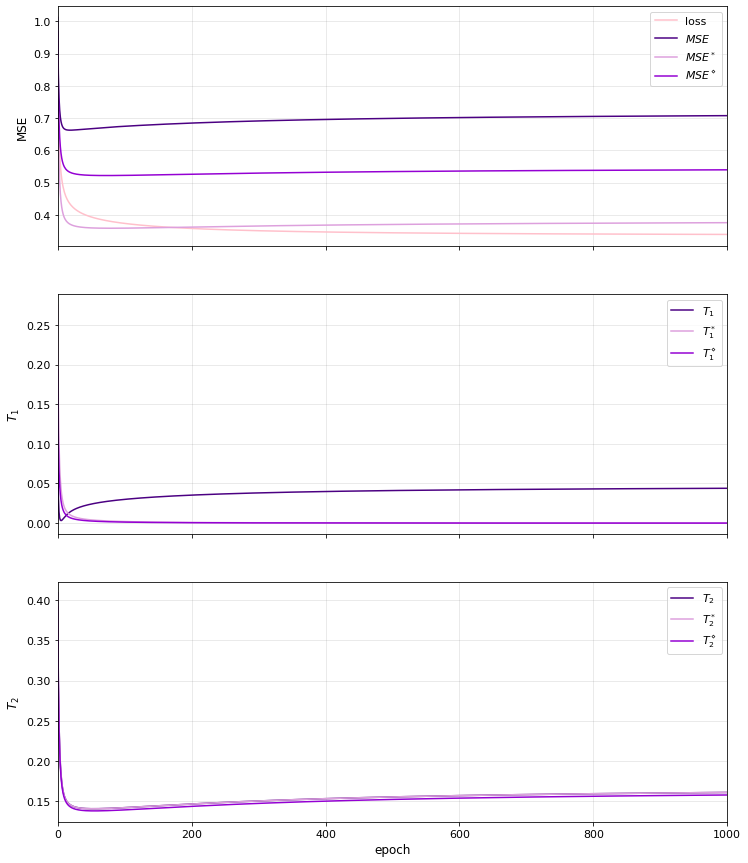

In [11]:
MSE = []
MSE_star =[]
MSE_diamond =[]

for i in range(3000):
    MSE.append(term_I_tab[i] + term_II_tab[i] + 1.0 - term_IV_tab[i])
    MSE_star.append(term_I_star_tab[i] + term_II_star_tab[i] + 1.0 - term_IV_star_tab[i])
    MSE_diamond.append(term_I_diamond_tab[i] + term_II_diamond_tab[i] + 1.0 - term_IV_diamond_tab[i])
    

fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

axs[0].plot(np.array(loss_tab)*10, color= 'pink', label = 'loss')

axs[0].plot(MSE, color= 'indigo', label = '$MSE$')
axs[1].plot(term_I_tab, color= 'indigo', label = '$T_1$')
axs[2].plot(term_II_tab, color= 'indigo', label = '$T_2$')
#axs[3].plot(term_IV_tab, color= 'indigo', label = 'original')

axs[0].plot(MSE_star, color= 'plum', label = '$MSE^*$')
axs[1].plot(term_I_star_tab, color= 'plum', label = '$T_1^*$')
axs[2].plot(term_II_star_tab, color= 'plum', label = '$T_2^*$')
#axs[3].plot(term_IV_star_tab, color= 'rebeccapurple', label = '$S^{31}$ improved')

axs[0].plot(MSE_diamond, color= 'darkviolet', label = '$MSE^\diamond$')
axs[1].plot(term_I_diamond_tab, color= 'darkviolet', label = '$T_1^\diamond$')
axs[2].plot(term_II_diamond_tab, color= 'darkviolet', label = '$T_2^\diamond$')
#axs[3].plot(term_IV_diamond_tab, color= 'plum', label = '$S^{11}$ improved')

for ax in axs:
    ax.grid(True, color='gray', alpha = 0.2)
    ax.legend(fontsize=11)
    ax.tick_params(axis='both', labelsize=11)


axs[0].set_ylabel('MSE', fontsize=12)
axs[1].set_ylabel('$T_1$',fontsize=12)
axs[2].set_ylabel('$T_2$',fontsize=12)
axs[-1].set_xlabel('epoch',fontsize=12)
axs[-1].set_xlim(0,1000)

In [13]:
df = pd.DataFrame()
df['loss'] = loss_tab
df['train_accuracy'] = train_accuracy_tab
df['test_accuracy'] = test_accuracy_tab

df['w1_mean'] = w1_mean_tab
df['w1_std'] = w1_std_tab
df['w2_mean'] = w2_mean_tab
df['w2_std'] = w2_std_tab

df['MSE'] = MSE
df['term_I'] = term_I_tab
df['term_II'] = term_II_tab
df['term_IV'] = term_IV_tab

df['MSE_star'] = MSE_star
df['term_I_star'] = term_I_star_tab
df['term_II_star'] = term_II_star_tab
df['term_IV_star'] = term_IV_star_tab

df['MSE_diamond']= MSE_diamond
df['term_I_diamond'] = term_I_diamond_tab
df['term_II_diamond'] = term_II_diamond_tab
df['term_IV_diamond'] = term_IV_diamond_tab

df.to_csv('terms_500.csv')